In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 4.5703345390527765
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 836.78it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 822.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 842.54it/s]


In [6]:
from dataset import optDatasetConstrs
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 616.61it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 1e-2
num_epochs = 20
log_step = 2

In [11]:
import time
from tqdm import tqdm

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### Exact Method 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="gurobi", processes=8)

Num of cores: 8


In [14]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  45.7817%, Val Regret:  40.6327%


Epoch    1, Loss:  -0.9990:  10%|█████▌                                                 | 2/20 [00:12<01:33,  5.17s/it]

Epoch   2, Train Regret:   3.4303%, Val Regret:   3.2009%


Epoch    3, Loss:  -1.0000:  20%|███████████                                            | 4/20 [00:19<00:59,  3.72s/it]

Epoch   4, Train Regret:   1.7188%, Val Regret:   1.3654%


Epoch    5, Loss:  -1.0000:  30%|████████████████▌                                      | 6/20 [00:25<00:45,  3.27s/it]

Epoch   6, Train Regret:   1.3486%, Val Regret:   0.9225%


Epoch    7, Loss:  -0.9997:  40%|██████████████████████                                 | 8/20 [00:31<00:37,  3.11s/it]

Epoch   8, Train Regret:   1.1150%, Val Regret:   1.0286%


Epoch    9, Loss:  -1.0000:  50%|███████████████████████████                           | 10/20 [00:37<00:30,  3.05s/it]

Epoch  10, Train Regret:   0.9594%, Val Regret:   0.8612%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [00:44<00:24,  3.03s/it]

Epoch  12, Train Regret:   0.9284%, Val Regret:   0.8520%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [00:50<00:17,  2.99s/it]

Epoch  14, Train Regret:   0.8175%, Val Regret:   0.8588%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [00:56<00:11,  2.98s/it]

Epoch  16, Train Regret:   0.7641%, Val Regret:   0.8187%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [01:02<00:05,  3.00s/it]

Epoch  18, Train Regret:   0.8194%, Val Regret:   0.6423%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.38s/it]


Epoch  19, Loss:  -1.0000, Train Regret:   0.7560%, Val Regret:   0.6849%

Evaluation:
Test Regret: 0.6519%
Training Elapsed Time: 32.94 Sec


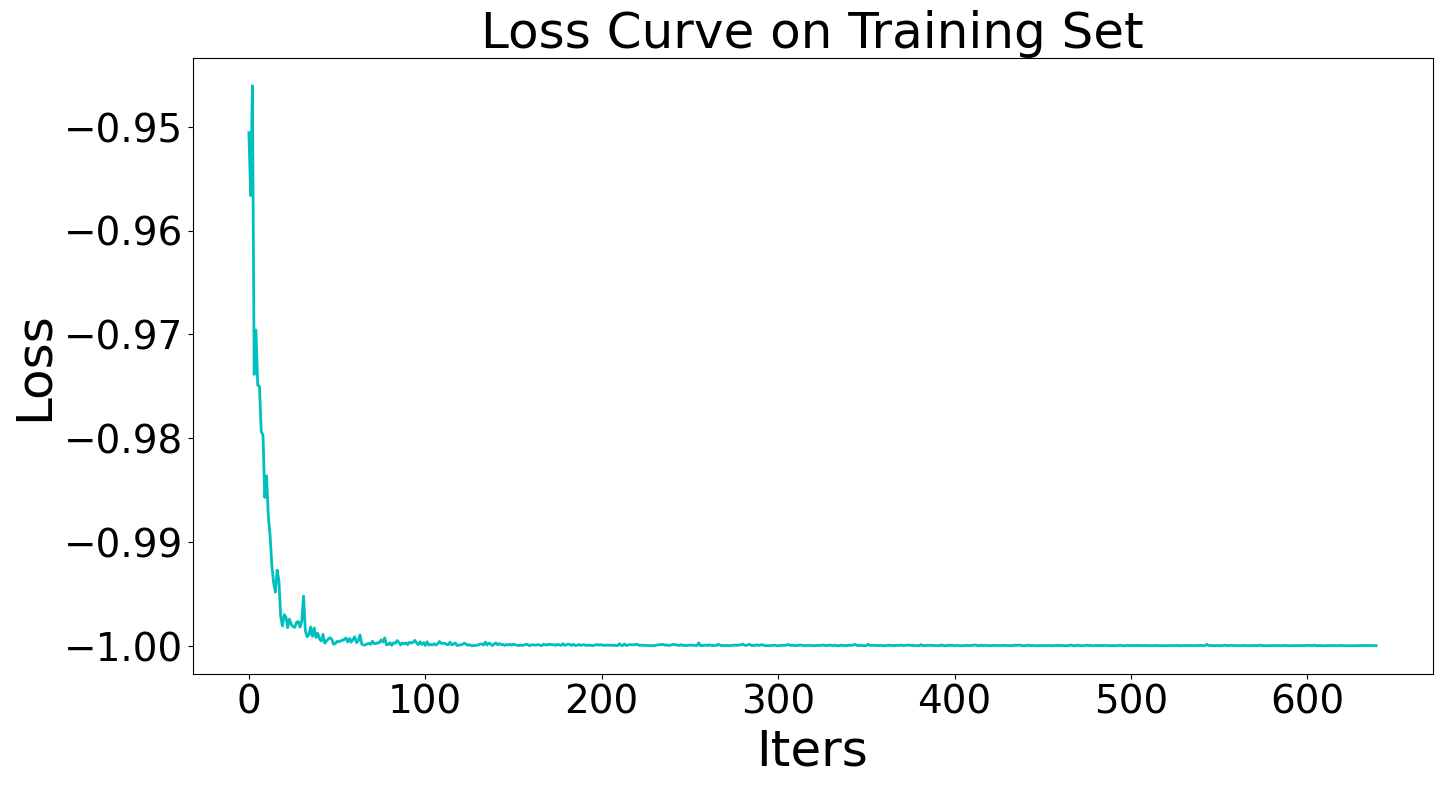

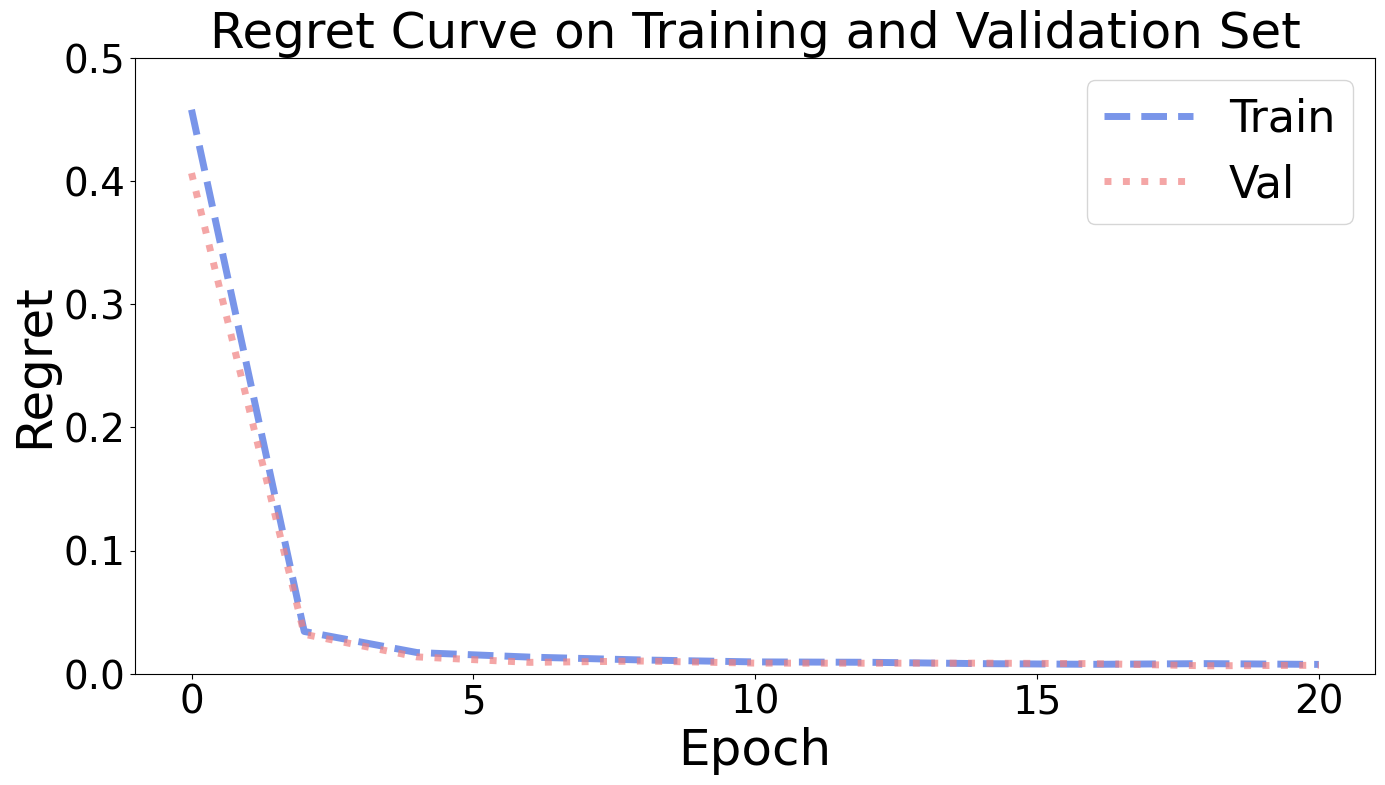

In [15]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method 

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [18]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  43.9374%, Val Regret:  41.3425%


Epoch    1, Loss:  -0.9971:  10%|█████▌                                                 | 2/20 [00:05<00:36,  2.04s/it]

Epoch   2, Train Regret:   2.4384%, Val Regret:   2.5661%


Epoch    3, Loss:  -1.0000:  20%|███████████                                            | 4/20 [00:10<00:32,  2.02s/it]

Epoch   4, Train Regret:   1.5199%, Val Regret:   1.6488%


Epoch    5, Loss:  -1.0000:  30%|████████████████▌                                      | 6/20 [00:14<00:28,  2.04s/it]

Epoch   6, Train Regret:   1.1414%, Val Regret:   1.3492%


Epoch    7, Loss:  -0.9998:  40%|██████████████████████                                 | 8/20 [00:18<00:24,  2.05s/it]

Epoch   8, Train Regret:   1.0166%, Val Regret:   0.9522%


Epoch    9, Loss:  -0.9999:  50%|███████████████████████████                           | 10/20 [00:23<00:20,  2.04s/it]

Epoch  10, Train Regret:   0.9006%, Val Regret:   1.0532%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [00:27<00:16,  2.05s/it]

Epoch  12, Train Regret:   0.8611%, Val Regret:   1.0617%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [00:31<00:12,  2.05s/it]

Epoch  14, Train Regret:   0.8199%, Val Regret:   0.9036%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [00:36<00:08,  2.08s/it]

Epoch  16, Train Regret:   0.7854%, Val Regret:   0.7704%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [00:40<00:04,  2.05s/it]

Epoch  18, Train Regret:   0.8158%, Val Regret:   0.7991%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.18s/it]


Epoch  19, Loss:  -1.0000, Train Regret:   0.7431%, Val Regret:   0.7715%

Evaluation:
Test Regret: 0.8043%
Training Elapsed Time: 8.58 Sec


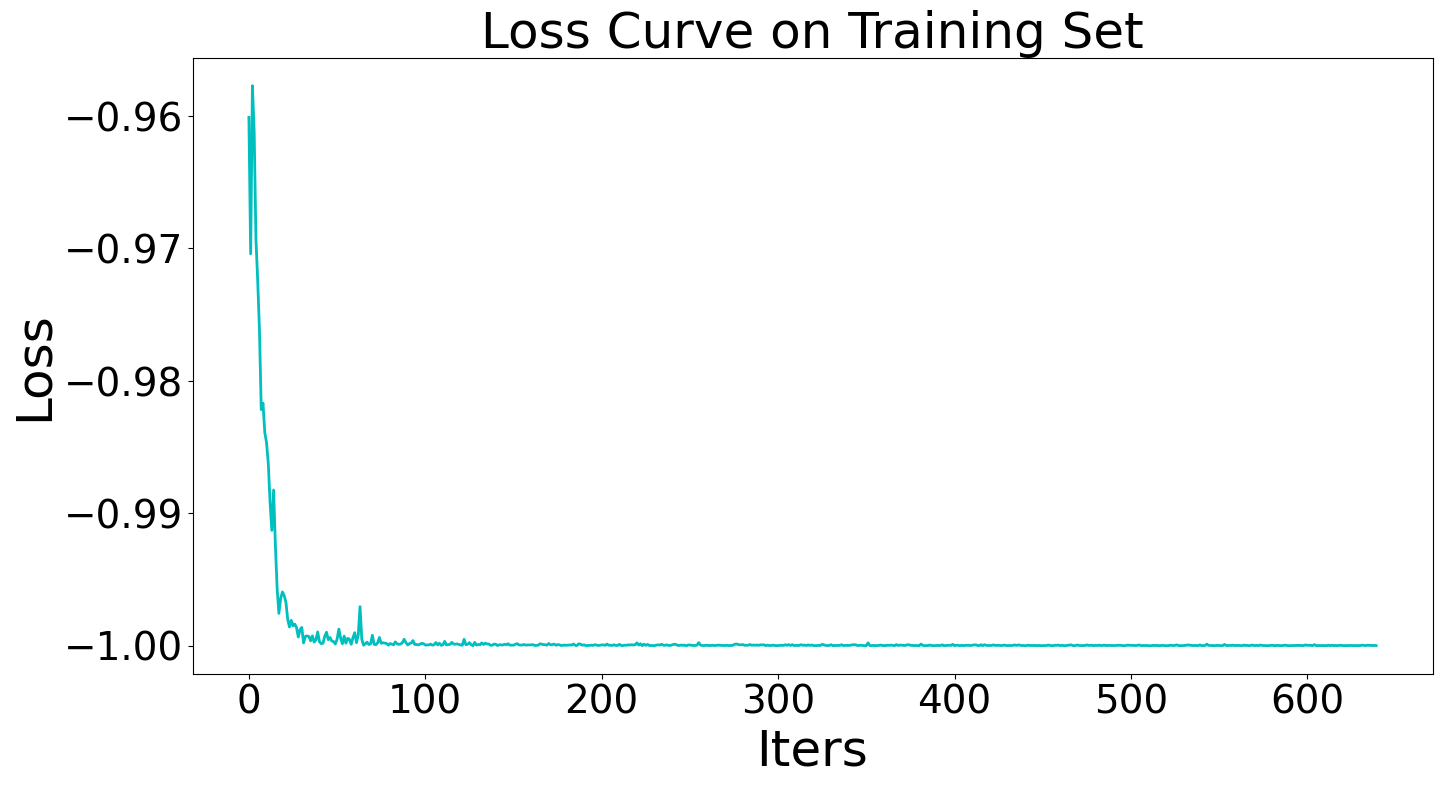

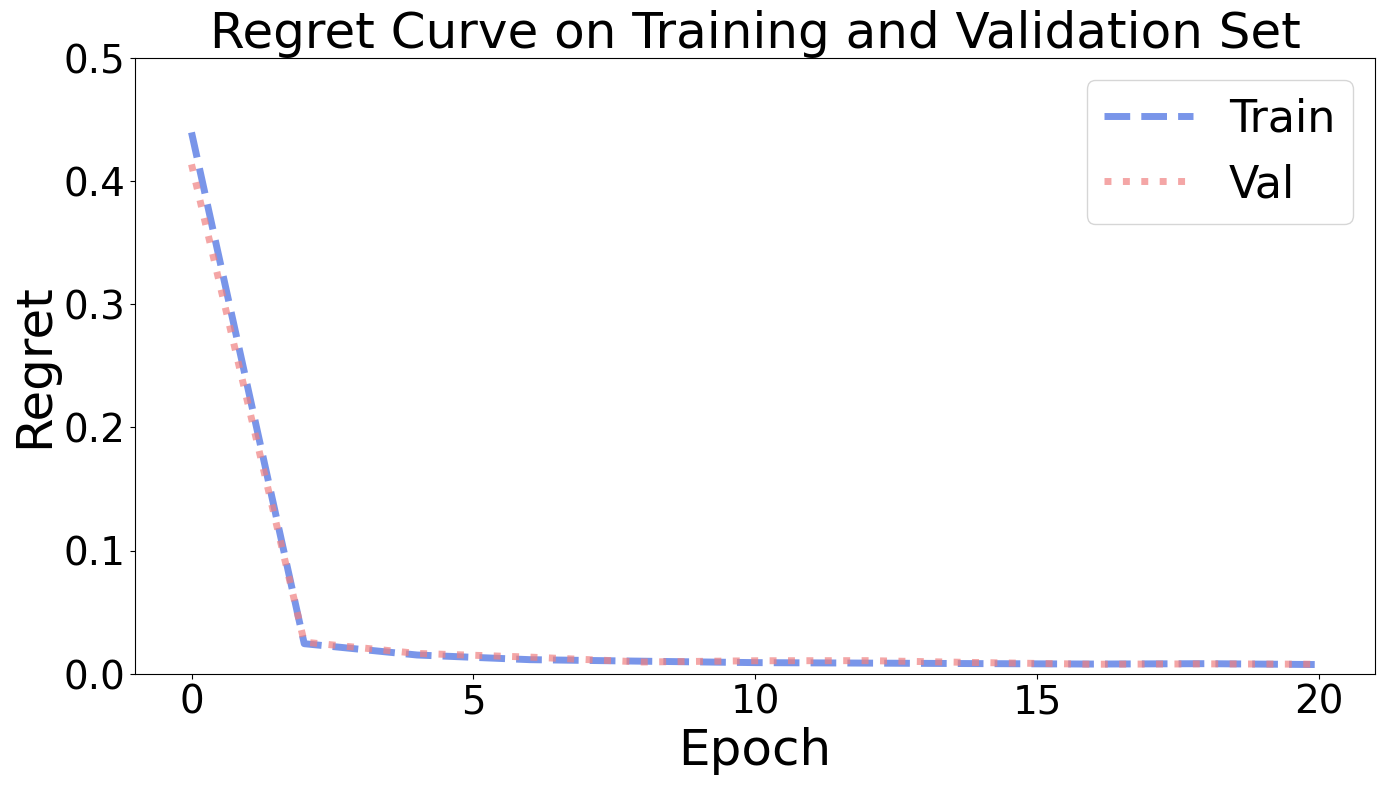

In [19]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Vector Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import avgConeAlignedCosine

# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [22]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  43.9374%, Val Regret:  41.3425%


Epoch    1, Loss:  -0.7484:  10%|█████▌                                                 | 2/20 [00:05<00:30,  1.71s/it]

Epoch   2, Train Regret:   3.2641%, Val Regret:   3.0294%


Epoch    3, Loss:  -0.7658:  20%|███████████                                            | 4/20 [00:08<00:27,  1.70s/it]

Epoch   4, Train Regret:   2.7109%, Val Regret:   2.9793%


Epoch    5, Loss:  -0.8027:  30%|████████████████▌                                      | 6/20 [00:12<00:24,  1.72s/it]

Epoch   6, Train Regret:   2.7264%, Val Regret:   2.9694%


Epoch    7, Loss:  -0.7278:  40%|██████████████████████                                 | 8/20 [00:16<00:20,  1.71s/it]

Epoch   8, Train Regret:   2.5554%, Val Regret:   3.0064%


Epoch    9, Loss:  -0.8049:  50%|███████████████████████████                           | 10/20 [00:19<00:17,  1.72s/it]

Epoch  10, Train Regret:   2.6968%, Val Regret:   2.9914%


Epoch   11, Loss:  -0.8344:  60%|████████████████████████████████▍                     | 12/20 [00:23<00:13,  1.71s/it]

Epoch  12, Train Regret:   2.7259%, Val Regret:   3.0883%


Epoch   13, Loss:  -0.8239:  70%|█████████████████████████████████████▊                | 14/20 [00:27<00:10,  1.72s/it]

Epoch  14, Train Regret:   2.5011%, Val Regret:   2.8708%


Epoch   15, Loss:  -0.8213:  80%|███████████████████████████████████████████▏          | 16/20 [00:31<00:06,  1.71s/it]

Epoch  16, Train Regret:   2.6166%, Val Regret:   2.8314%


Epoch   17, Loss:  -0.8198:  90%|████████████████████████████████████████████████▌     | 18/20 [00:34<00:03,  1.73s/it]

Epoch  18, Train Regret:   2.7125%, Val Regret:   3.0158%


Epoch   19, Loss:  -0.8258: 100%|██████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.85s/it]


Epoch  19, Loss:  -0.8258, Train Regret:   2.4508%, Val Regret:   3.0656%

Evaluation:
Test Regret: 3.0070%
Training Elapsed Time: 1.75 Sec


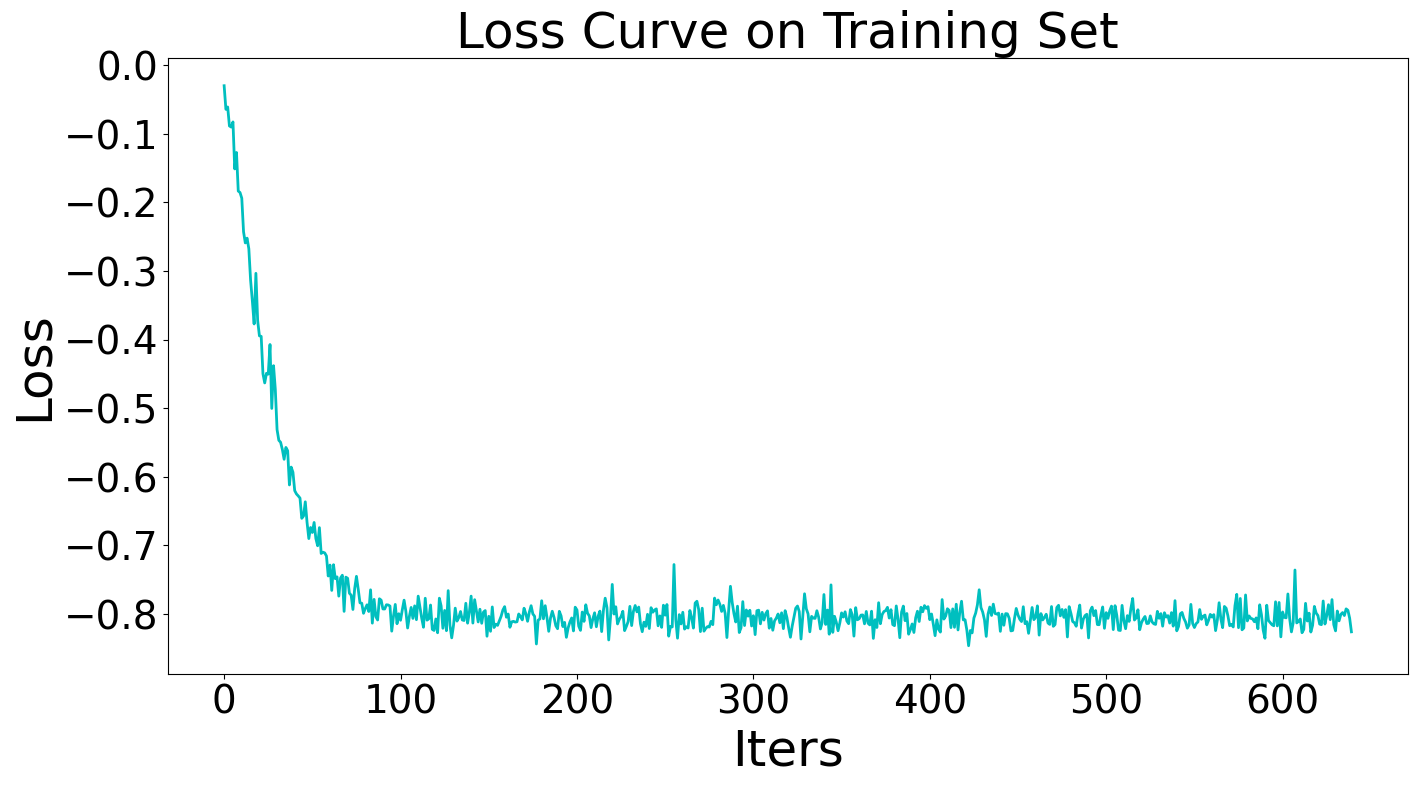

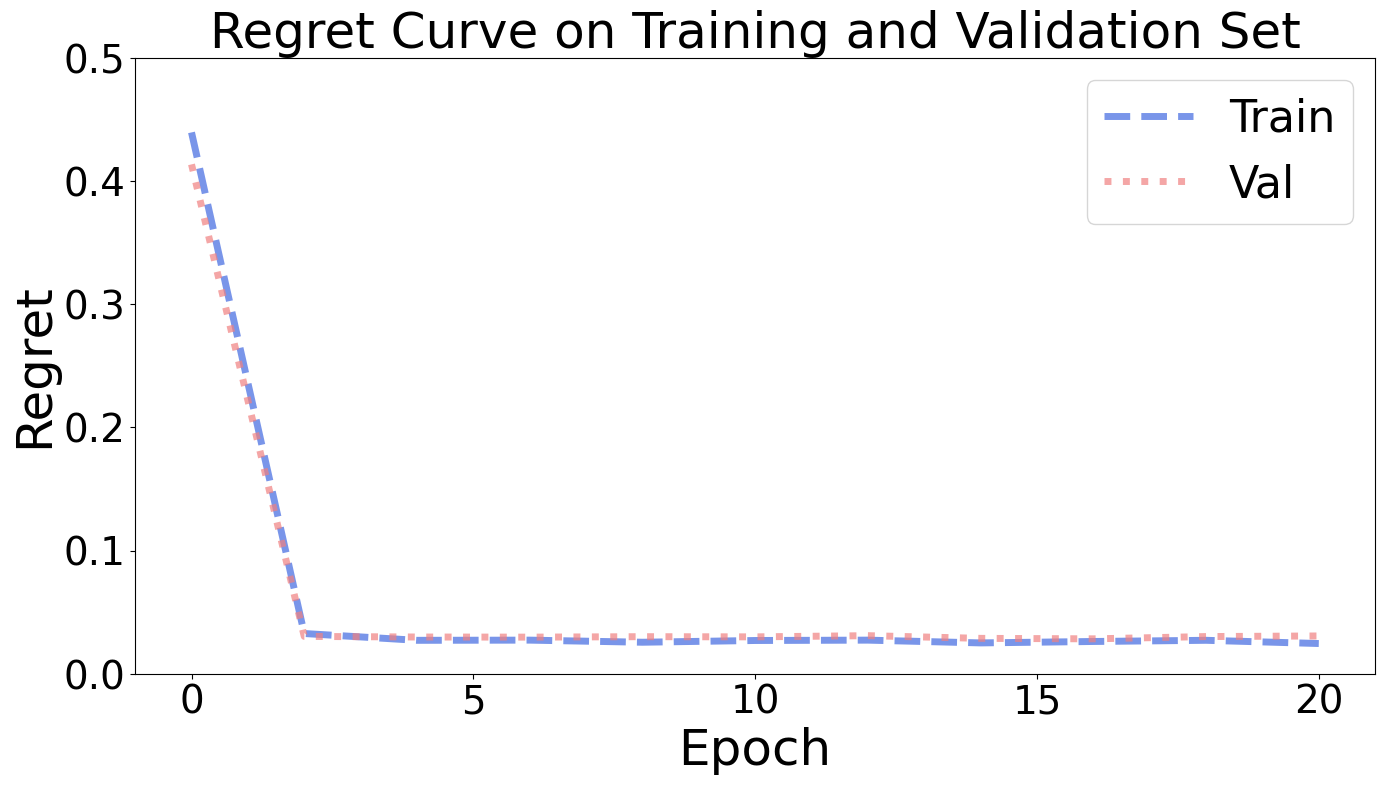

In [23]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  43.9374%, Val Regret:  41.3425%


Epoch    1, Loss:  -0.6680:  10%|█████▌                                                 | 2/20 [00:06<00:39,  2.20s/it]

Epoch   2, Train Regret:   3.4675%, Val Regret:   3.0155%


Epoch    3, Loss:  -0.6963:  20%|███████████                                            | 4/20 [00:10<00:32,  2.00s/it]

Epoch   4, Train Regret:   2.7516%, Val Regret:   2.8557%


Epoch    5, Loss:  -0.6781:  30%|████████████████▌                                      | 6/20 [00:14<00:27,  1.94s/it]

Epoch   6, Train Regret:   2.5873%, Val Regret:   3.0122%


Epoch    7, Loss:  -0.6502:  40%|██████████████████████                                 | 8/20 [00:18<00:23,  1.96s/it]

Epoch   8, Train Regret:   2.6890%, Val Regret:   2.9765%


Epoch    9, Loss:  -0.6806:  50%|███████████████████████████                           | 10/20 [00:22<00:19,  1.95s/it]

Epoch  10, Train Regret:   2.6734%, Val Regret:   2.8486%


Epoch   11, Loss:  -0.7142:  60%|████████████████████████████████▍                     | 12/20 [00:26<00:15,  1.94s/it]

Epoch  12, Train Regret:   2.5609%, Val Regret:   3.0498%


Epoch   13, Loss:  -0.7082:  70%|█████████████████████████████████████▊                | 14/20 [00:31<00:11,  1.95s/it]

Epoch  14, Train Regret:   2.5778%, Val Regret:   2.9779%


Epoch   15, Loss:  -0.7253:  80%|███████████████████████████████████████████▏          | 16/20 [00:35<00:07,  1.95s/it]

Epoch  16, Train Regret:   2.4722%, Val Regret:   2.8703%


Epoch   17, Loss:  -0.7021:  90%|████████████████████████████████████████████████▌     | 18/20 [00:39<00:03,  1.94s/it]

Epoch  18, Train Regret:   2.7421%, Val Regret:   3.0461%


Epoch   19, Loss:  -0.7187: 100%|██████████████████████████████████████████████████████| 20/20 [00:41<00:00,  2.10s/it]


Epoch  19, Loss:  -0.7187, Train Regret:   2.6842%, Val Regret:   2.9995%

Evaluation:
Test Regret: 2.8888%
Training Elapsed Time: 6.81 Sec


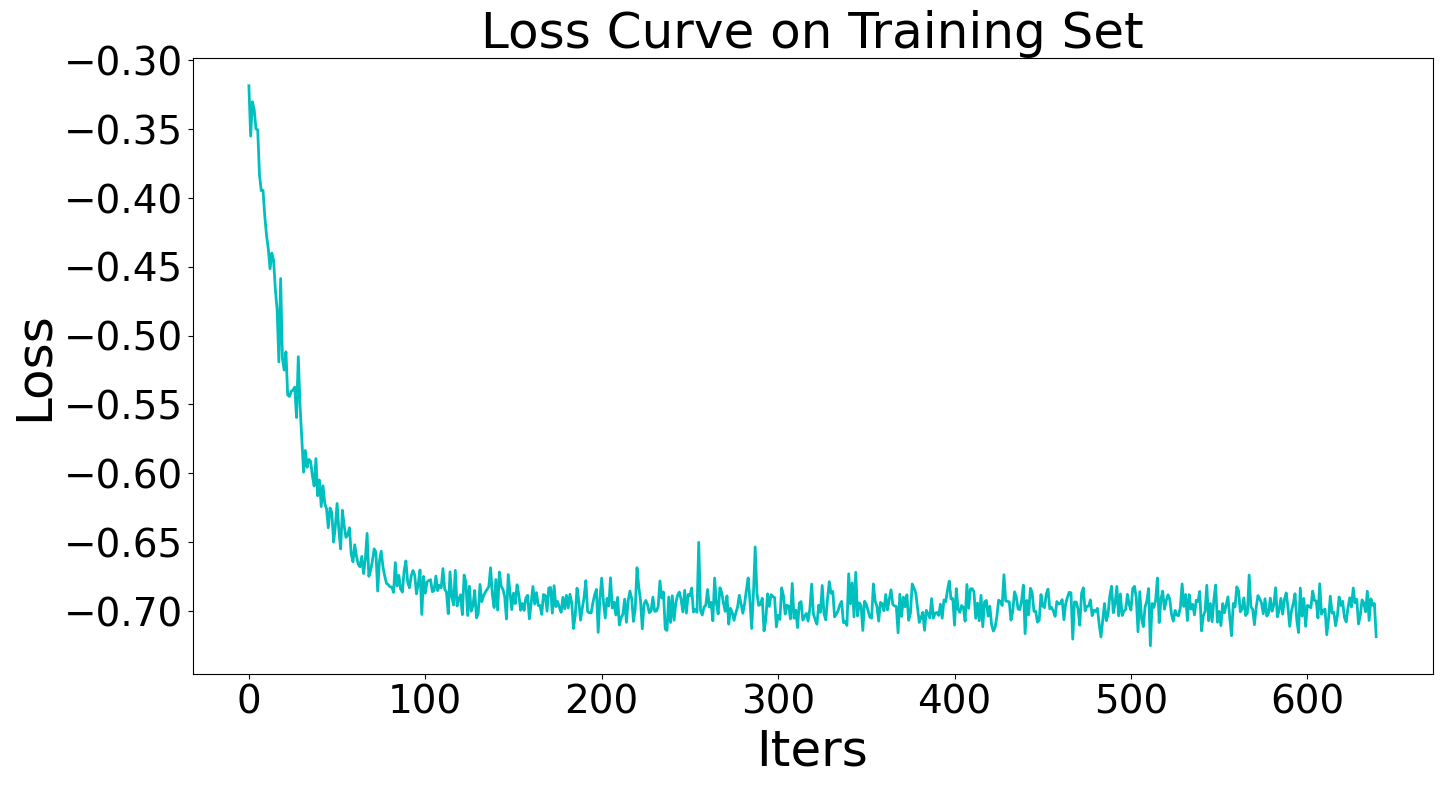

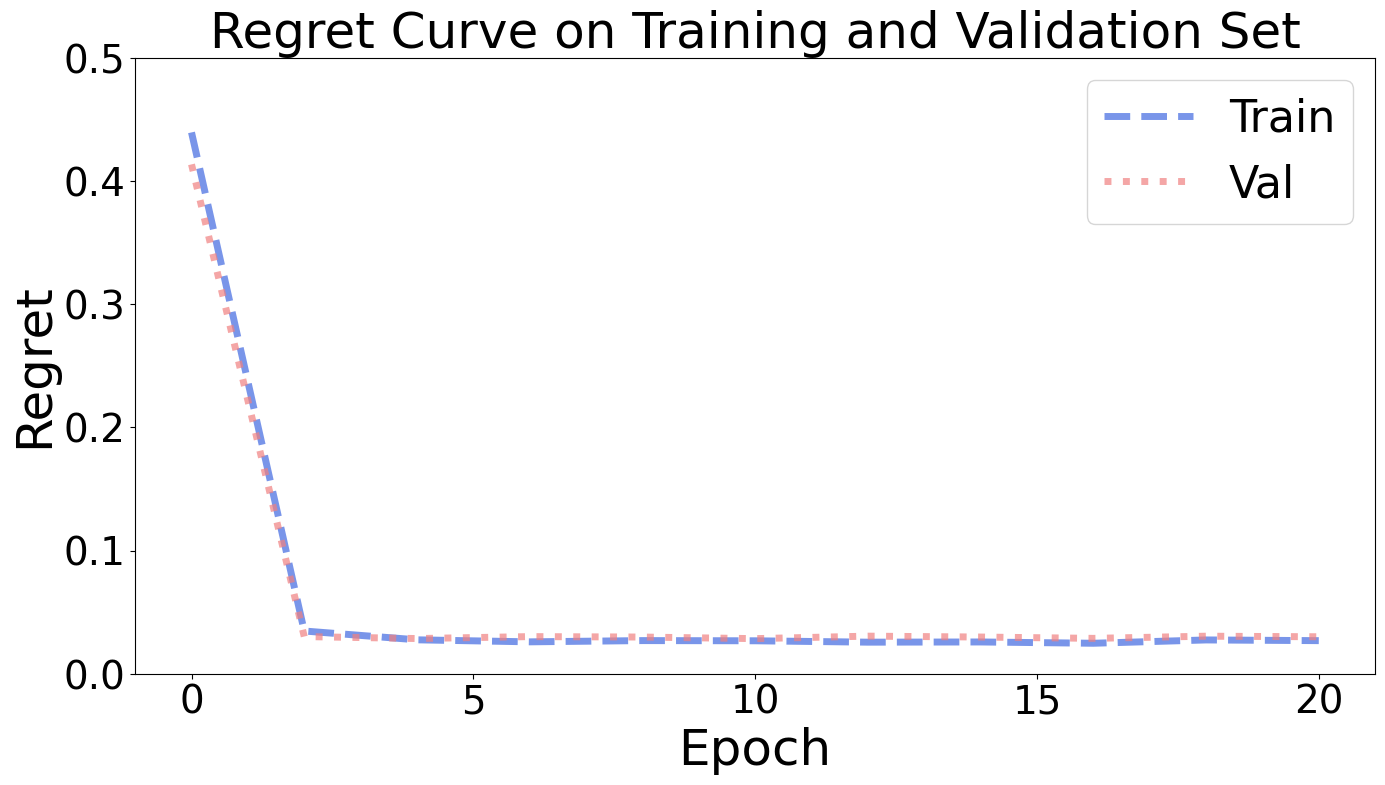

In [27]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [30]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  43.9374%, Val Regret:  41.3425%


Epoch    1, Loss:  -0.9806:  10%|█████▌                                                 | 2/20 [00:05<00:34,  1.91s/it]

Epoch   2, Train Regret:   6.0666%, Val Regret:   5.8040%


Epoch    3, Loss:  -0.9913:  20%|███████████                                            | 4/20 [00:09<00:28,  1.78s/it]

Epoch   4, Train Regret:   3.3937%, Val Regret:   2.9392%


Epoch    5, Loss:  -0.9942:  30%|████████████████▌                                      | 6/20 [00:13<00:24,  1.76s/it]

Epoch   6, Train Regret:   2.7458%, Val Regret:   3.0021%


Epoch    7, Loss:  -0.9887:  40%|██████████████████████                                 | 8/20 [00:16<00:20,  1.72s/it]

Epoch   8, Train Regret:   2.5094%, Val Regret:   2.7192%


Epoch    9, Loss:  -0.9976:  50%|███████████████████████████                           | 10/20 [00:20<00:17,  1.73s/it]

Epoch  10, Train Regret:   2.4775%, Val Regret:   2.3831%


Epoch   11, Loss:  -0.9977:  60%|████████████████████████████████▍                     | 12/20 [00:24<00:13,  1.72s/it]

Epoch  12, Train Regret:   2.5458%, Val Regret:   2.3288%


Epoch   13, Loss:  -0.9971:  70%|█████████████████████████████████████▊                | 14/20 [00:28<00:10,  1.72s/it]

Epoch  14, Train Regret:   2.8911%, Val Regret:   2.4265%


Epoch   15, Loss:  -0.9968:  80%|███████████████████████████████████████████▏          | 16/20 [00:31<00:06,  1.74s/it]

Epoch  16, Train Regret:   3.2348%, Val Regret:   2.7223%


Epoch   17, Loss:  -0.9988:  90%|████████████████████████████████████████████████▌     | 18/20 [00:35<00:03,  1.73s/it]

Epoch  18, Train Regret:   3.6221%, Val Regret:   3.1679%


Epoch   19, Loss:  -0.9967: 100%|██████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.88s/it]


Epoch  19, Loss:  -0.9967, Train Regret:   4.0361%, Val Regret:   4.0272%

Evaluation:
Test Regret: 3.7918%
Training Elapsed Time: 2.31 Sec


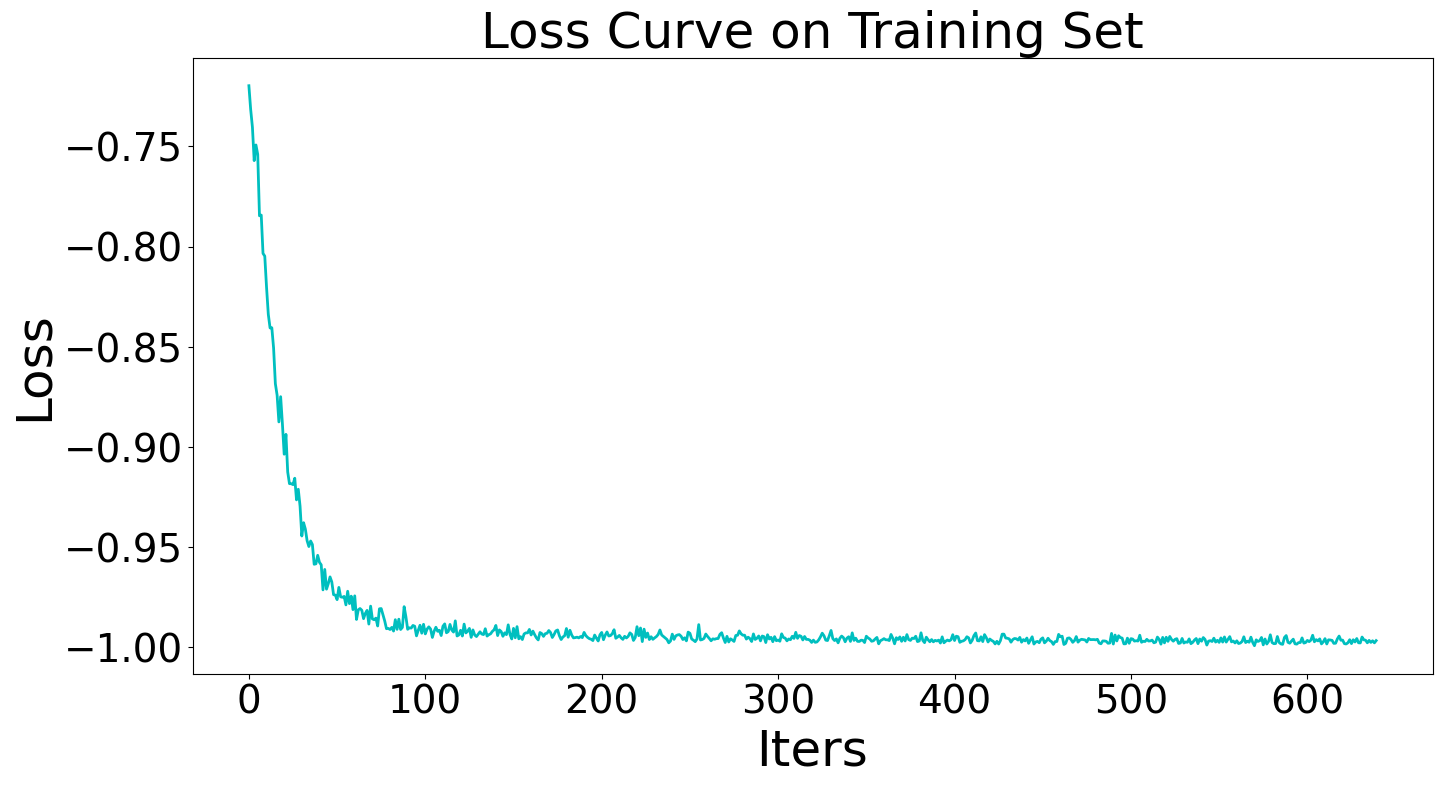

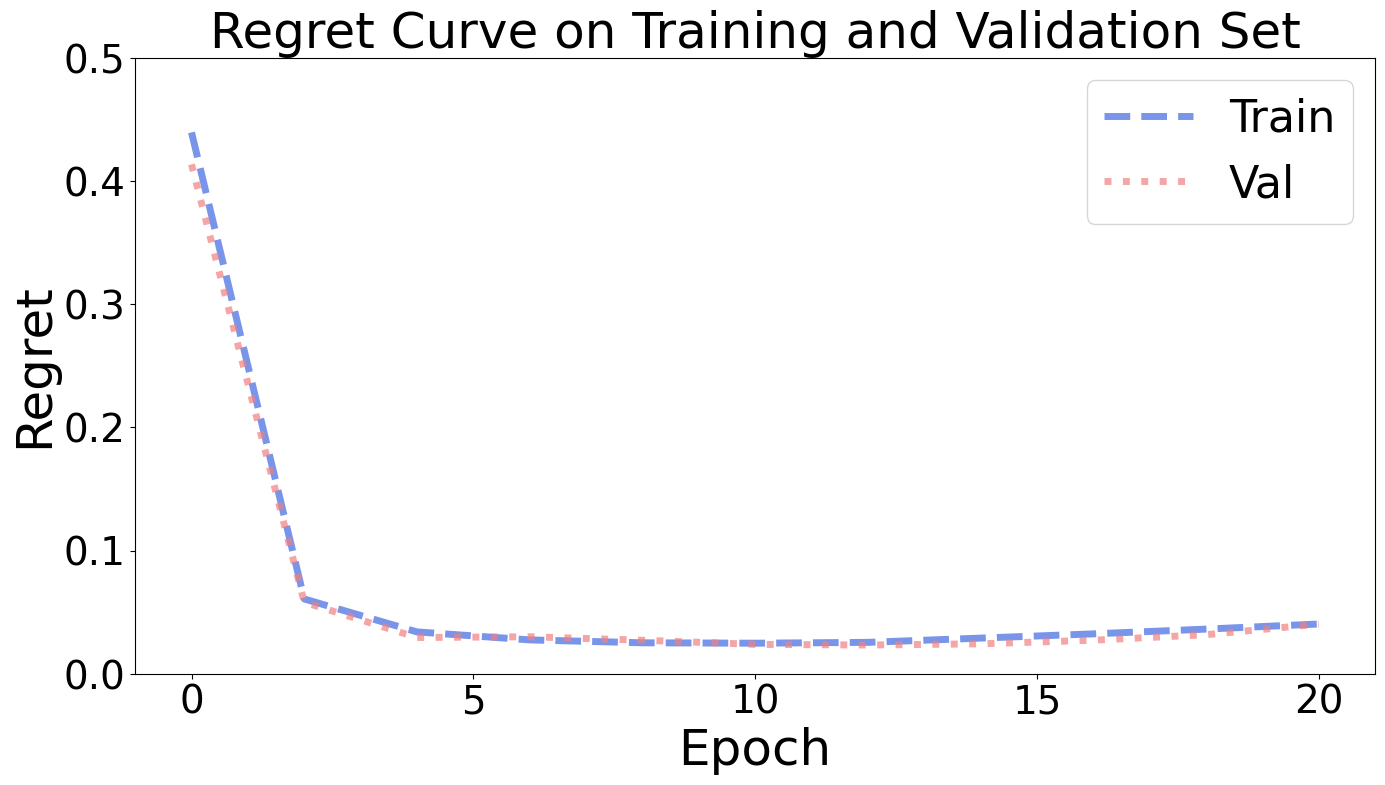

In [31]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)